# 👗 Fashion Trend Intelligence

## Analyse des tendances mode avec segmentation sémantique via API Hugging Face

Ce notebook utilise l'**API Hugging Face** pour analyser automatiquement les vêtements et accessoires dans des images de mode.

### 🎯 Objectifs
- Segmenter automatiquement les éléments de mode (vêtements, accessoires, corps)
- Identifier 18 classes différentes : chapeaux, vêtements, chaussures, sacs, etc.
- Évaluer la performance du modèle de segmentation
- Générer des rapports visuels et statistiques

### 📊 Fonctionnalités
- ✅ Appels API vers le modèle `sayeed99/segformer_b3_clothes`
- ✅ Traitement par lot d'images
- ✅ Visualisation avec masques colorés
- ✅ Métriques d'évaluation (IoU, Pixel Accuracy)
- ✅ Rapport automatique avec graphiques

### 🚀 Compatible Google Colab
Notebook optimisé pour fonctionner directement dans Google Colab sans installation complexe.

## 🔧 Configuration et Installation

Cette section prépare l'environnement de travail en installant les packages nécessaires et en téléchargeant le dataset.

### Étapes de configuration :
1. **Installation des packages** - Librairies Python pour le traitement d'images et les appels API
2. **Téléchargement du dataset** - Images de mode pour les tests
3. **Configuration des classes** - Définition des 18 catégories de mode à détecter

### 📦 Installation des packages nécessaires

Les packages suivants sont requis pour le fonctionnement du notebook :
- `requests` : Pour les appels API vers Hugging Face
- `opencv-python` : Traitement et manipulation d'images
- `pillow` : Gestion des formats d'images
- `numpy` : Calculs numériques et manipulation de tableaux
- `scikit-learn` : Métriques d'évaluation (IoU)
- `matplotlib` : Génération de graphiques
- `tqdm` : Barres de progression

**⏳ Cette installation peut prendre quelques minutes...**

In [1]:
!pip install requests opencv-python pillow numpy scikit-learn matplotlib tqdm

### 📚 Chargement des librairies

Importation de toutes les librairies nécessaires pour :
- **Appels API** : `requests` pour communiquer avec Hugging Face
- **Traitement d'images** : `cv2`, `PIL`, `numpy` pour manipuler les images
- **Évaluation** : `sklearn.metrics` pour calculer les performances
- **Visualisation** : `matplotlib` pour les graphiques
- **Utilitaires** : `tqdm`, `json`, `base64` pour diverses fonctions

In [2]:
# === IMPORTS ESSENTIELS ===

# Gestion des fichiers et système
import os
import json
import zipfile
import time

# Appels API et réseau
import requests
from tqdm import tqdm

# Traitement d'images
import cv2
import base64
import io
from PIL import Image
import numpy as np

# Évaluation et métriques
from sklearn.metrics import jaccard_score

# Visualisation
import matplotlib.pyplot as plt

print("✅ Toutes les librairies ont été chargées avec succès !")
print("🔗 Prêt pour les appels API Hugging Face")
print("🖼️ Prêt pour le traitement d'images")
print("📊 Prêt pour l'évaluation et la visualisation")

✅ Toutes les librairies ont été chargées avec succès !
🔗 Prêt pour les appels API Hugging Face
🖼️ Prêt pour le traitement d'images
📊 Prêt pour l'évaluation et la visualisation


In [3]:
# === TÉLÉCHARGEMENT AUTOMATIQUE DU DATASET ===

# URL et chemins de destination
zip_url = "https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/2053_AI+Engineer/top_influenceurs_2024-20250314T143221Z-001+(1).zip"
zip_path = "content/top_influenceurs_2024.zip"
extract_dir = "content"

# Création du répertoire de destination
os.makedirs(extract_dir, exist_ok=True)

# Vérification si le dataset existe déjà
if not os.path.exists("content/top_influenceurs_2024"):
    print("🔄 Téléchargement du dataset en cours...")
    print("📦 Taille approximative : ~50MB")

    # Téléchargement avec barre de progression
    with requests.get(zip_url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

    print("📂 Extraction des fichiers...")
    # Extraction du fichier ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Nettoyage du fichier ZIP temporaire
    os.remove(zip_path)
    print("✅ Dataset téléchargé et extrait avec succès !")
    print("📊 50 images de mode disponibles pour l'analyse")
else:
    print("✅ Dataset déjà présent dans le système")
    print("📂 Répertoire : content/top_influenceurs_2024/")

🔄 Téléchargement du dataset en cours...
📦 Taille approximative : ~50MB
📂 Extraction des fichiers...
✅ Dataset téléchargé et extrait avec succès !
📊 50 images de mode disponibles pour l'analyse


### 📥 Téléchargement du dataset de mode

Cette cellule télécharge automatiquement le dataset d'images de mode contenant :
- **50 images** d'influenceurs mode
- **Masques de segmentation** ground truth correspondants
- **Structure organisée** : IMG/, Mask/, Expected_Results/

**⚡ Le téléchargement se fait une seule fois** - si le dataset existe déjà, cette étape sera ignorée.

### ⚙️ Configuration des classes et paramètres

Cette section définit les éléments essentiels pour la segmentation :

#### 🏷️ Classes de mode détectées (18 catégories)
- **Vêtements** : Upper-clothes, Pants, Skirt, Dress
- **Accessoires** : Hat, Sunglasses, Belt, Bag, Scarf  
- **Chaussures** : Left-shoe, Right-shoe
- **Corps humain** : Face, Hair, Left/Right-arm, Left/Right-leg
- **Arrière-plan** : Background

#### 🎨 Système de couleurs
Chaque classe a une couleur unique pour la visualisation des masques.

#### 📁 Structure des dossiers
Organisation automatique des résultats d'analyse.

In [4]:
# === CONFIGURATION DES CLASSES DE MODE ===

# Mapping des 18 classes de segmentation mode
CLASS_MAPPING = {
    "Background": 0,     # Arrière-plan
    "Hat": 1,           # Chapeau
    "Hair": 2,          # Cheveux
    "Sunglasses": 3,    # Lunettes de soleil
    "Upper-clothes": 4, # Vêtements du haut
    "Skirt": 5,         # Jupe
    "Pants": 6,         # Pantalon
    "Dress": 7,         # Robe
    "Belt": 8,          # Ceinture
    "Left-shoe": 9,     # Chaussure gauche
    "Right-shoe": 10,   # Chaussure droite
    "Face": 11,         # Visage
    "Left-leg": 12,     # Jambe gauche
    "Right-leg": 13,    # Jambe droite
    "Left-arm": 14,     # Bras gauche
    "Right-arm": 15,    # Bras droit
    "Bag": 16,          # Sac
    "Scarf": 17         # Écharpe
}

# Correspondance inverse pour l'affichage
LABELS_MAPPING = {str(v): k for k, v in CLASS_MAPPING.items()}

# === PALETTE DE COULEURS POUR VISUALISATION ===
# Chaque classe a une couleur RGB unique
COLOR_MAPPING = {
    1: (255, 255, 0),   # Hat - Jaune
    2: (255, 165, 0),   # Hair - Orange
    3: (255, 0, 255),   # Sunglasses - Magenta
    4: (255, 0, 0),     # Upper-clothes - Rouge
    5: (0, 255, 255),   # Skirt - Cyan
    6: (0, 255, 0),     # Pants - Vert
    7: (0, 0, 255),     # Dress - Bleu
    8: (128, 0, 128),   # Belt - Violet
    9: (255, 140, 0),   # Left-shoe - Orange foncé
    10: (139, 69, 19),  # Right-shoe - Marron
    11: (255, 220, 177), # Face - Chair
    12: (205, 170, 125), # Left-leg - Chair foncé
    13: (185, 150, 105), # Right-leg - Chair moyen
    14: (225, 190, 145), # Left-arm - Chair clair
    15: (165, 130, 85),  # Right-arm - Chair sombre
    16: (255, 82, 243),  # Bag - Rose vif
    17: (255, 20, 147)   # Scarf - Rose foncé
}

# === STRUCTURE DES DOSSIERS ===
IMG_DIR = "content/top_influenceurs_2024/IMG"           # Images originales
MASK_DIR = "content/top_influenceurs_2024/Mask"        # Masques ground truth
API_OUTPUTS_DIR = "content/top_influenceurs_2024/Output_API"  # Résultats de l'API
RESULTS_DIR = "content/top_influenceurs_2024/Real_Results"    # Visualisations finales
TEMPLATE_DIR = "content/templates"                      # Templates de rapport

# Création automatique des répertoires de sortie
print("📁 Création de la structure des dossiers...")
for directory in [API_OUTPUTS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(os.path.join(directory, "IMG"), exist_ok=True)
    os.makedirs(os.path.join(directory, "Mask"), exist_ok=True)

os.makedirs(TEMPLATE_DIR, exist_ok=True)

print("✅ Configuration terminée !")
print(f"🎯 {len(CLASS_MAPPING)} classes de mode configurées")
print(f"🎨 {len(COLOR_MAPPING)} couleurs définies pour la visualisation")
print("📂 Structure des dossiers créée")

📁 Création de la structure des dossiers...
✅ Configuration terminée !
🎯 18 classes de mode configurées
🎨 17 couleurs définies pour la visualisation
📂 Structure des dossiers créée


In [5]:
# === CONFIGURATION DU TOKEN HUGGING FACE ===

print("🔍 Recherche du token Hugging Face...")

# Tentative 1 : Variables d'environnement système
HF_TOKEN = os.environ.get('HF_TOKEN')

# Tentative 2 : Secrets Google Colab (méthode recommandée)
if not HF_TOKEN:
    try:
        from google.colab import userdata
        HF_TOKEN = userdata.get('HF_TOKEN')
        print("✅ Token trouvé dans les Secrets Google Colab")
    except:
        print("⚠️ Google Colab non détecté ou secrets non configurés")

# Vérification finale
if not HF_TOKEN:
    print("❌ TOKEN MANQUANT !")
    print("📋 Instructions :")
    print("   1. Créez un compte sur huggingface.co")
    print("   2. Générez un token dans Settings > Access Tokens")
    print("   3. Dans Colab : 🔒 Secrets → Ajouter 'HF_TOKEN'")
    print("   4. Redémarrez le runtime")
else:
    print("✅ Token Hugging Face configuré avec succès !")
    print("🚀 Prêt pour les appels API vers le modèle de segmentation")

🔍 Recherche du token Hugging Face...
✅ Token trouvé dans les Secrets Google Colab
✅ Token Hugging Face configuré avec succès !
🚀 Prêt pour les appels API vers le modèle de segmentation


### 🔑 Configuration du token Hugging Face

Pour utiliser l'API Hugging Face, un token d'authentification est requis.

#### 📋 Instructions :
1. **Créer un compte** sur [huggingface.co](https://huggingface.co)
2. **Générer un token** dans Settings > Access Tokens
3. **Dans Google Colab** : Aller dans 🔒 Secrets → Ajouter `HF_TOKEN`

⚠️ **Important** : Sans token valide, les appels API échoueront.

## 🛠️ Fonctions principales

Cette section contient toutes les fonctions nécessaires au fonctionnement du système :

### 📋 Vue d'ensemble des fonctions :
- **🔗 API Hugging Face** : Communication avec le modèle de segmentation
- **🖼️ Traitement d'images** : Manipulation des masques et visualisation  
- **⚙️ Pipeline de segmentation** : Traitement automatisé par lots
- **📊 Évaluation** : Calcul des métriques de performance

### 🔗 Fonction d'appel API Hugging Face

Cette fonction communique avec le modèle `sayeed99/segformer_b3_clothes` pour effectuer la segmentation sémantique.

#### ⚡ Fonctionnement :
- Envoi de l'image en format binaire vers l'API
- Réception des masques de segmentation en base64
- Gestion automatique des erreurs et timeouts
- Retour des résultats au format JSON

In [6]:
def call_hf_segmentation_api(image_path, model="sayeed99/segformer_b3_clothes"):
    """
    Appelle l'API Hugging Face pour la segmentation sémantique d'images de mode

    Args:
        image_path (str): Chemin vers l'image à segmenter
        model (str): Nom du modèle HF à utiliser

    Returns:
        list/None: Liste des masques de segmentation ou None en cas d'erreur
    """
    # Vérification du token d'authentification
    if not HF_TOKEN:
        print("❌ Token Hugging Face requis pour les appels API")
        return None

    # Construction de l'URL de l'API
    API_URL = f"https://api-inference.huggingface.co/models/{model}"
    headers = {"Authorization": f"Bearer {HF_TOKEN}"}

    try:
        # Lecture de l'image en mode binaire
        with open(image_path, "rb") as f:
            data = f.read()

        # Envoi de la requête POST vers l'API
        response = requests.post(
            API_URL,
            headers={"Content-Type": "image/jpeg", **headers},
            data=data
        )

        # Traitement de la réponse
        if response.status_code == 200:
            print(f"✅ Segmentation réussie pour {os.path.basename(image_path)}")
            return response.json()
        else:
            print(f"❌ Erreur API {response.status_code} pour {os.path.basename(image_path)}")
            print(f"Détails: {response.text}")
            return None

    except Exception as e:
        print(f"❌ Erreur lors de l'appel API : {e}")
        return None

print("✅ Fonction d'appel API chargée")
print("🎯 Modèle cible : sayeed99/segformer_b3_clothes")

# Test de connectivité (optionnel)
print("🔍 Test de connectivité avec le premier échantillon...")
test_result = call_hf_segmentation_api("/content/content/top_influenceurs_2024/IMG/image_0.png")
if test_result:
    print(f"🎉 API opérationnelle ! {len(test_result)} masques détectés")
else:
    print("⚠️ Test échoué - vérifiez le token et la connectivité")

✅ Fonction d'appel API chargée
🎯 Modèle cible : sayeed99/segformer_b3_clothes
🔍 Test de connectivité avec le premier échantillon...
✅ Segmentation réussie pour image_0.png
🎉 API opérationnelle ! 11 masques détectés


### 🖼️ Fonctions de traitement d'images

Cette section contient les fonctions pour manipuler et visualiser les résultats de segmentation.

#### 🔧 Fonctionnalités :
- **Décodage base64** : Conversion des masques API en tableaux NumPy
- **Combinaison de masques** : Fusion des différentes classes en un masque unique
- **Colorisation** : Application des couleurs définies pour chaque classe
- **Redimensionnement** : Adaptation aux dimensions des images originales
- **Sauvegarde des résultats** : Export des visualisations finales

In [7]:
def get_image_dimensions(img_path):
    """
    Obtient les dimensions (largeur, hauteur) d'une image

    Args:
        img_path (str): Chemin vers l'image
    Returns:
        tuple: (largeur, hauteur) en pixels
    """
    with Image.open(img_path) as img:
        return img.size

def decode_base64_mask(base64_string, width, height):
    """
    Décode un masque de segmentation depuis le format base64 de l'API

    Args:
        base64_string (str): Masque encodé en base64
        width, height (int): Dimensions cibles pour le redimensionnement
    Returns:
        numpy.ndarray: Masque décodé et redimensionné
    """
    # Décodage base64 vers image
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)

    # Conversion en niveaux de gris si nécessaire
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]

    # Redimensionnement aux dimensions originales
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    """
    Combine tous les masques de classes en un seul masque de segmentation

    Args:
        results (list): Résultats de l'API contenant les masques par classe
        width, height (int): Dimensions de l'image originale
    Returns:
        numpy.ndarray: Masque combiné avec les IDs de classes
    """
    # Initialisation du masque combiné (fond = 0)
    combined_mask = np.zeros((height, width), dtype=np.uint8)

    print(f"🔄 Traitement de {len(results)} masques de classes...")

    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)

        # Ignorer les classes non reconnues
        if class_id == 0:
            continue

        # Décodage et application du masque
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

        print(f"  ✅ {label} (ID: {class_id}) appliqué")

    return combined_mask

def colorize_mask(mask, colormap):
    """
    Applique la palette de couleurs au masque de segmentation

    Args:
        mask (numpy.ndarray): Masque avec IDs de classes
        colormap (dict): Mapping couleur par classe
    Returns:
        numpy.ndarray: Image colorée RGB
    """
    # Création de l'image colorée (RGB)
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    # Application des couleurs par classe
    for class_id, color in colormap.items():
        colored_mask[mask == class_id] = color

    return colored_mask

print("✅ Fonctions de traitement d'images chargées")
print("🎨 Prêt pour le décodage, la combinaison et la colorisation des masques")

✅ Fonctions de traitement d'images chargées
🎨 Prêt pour le décodage, la combinaison et la colorisation des masques


In [8]:
def save_results(image_dir, mask_dir, output_dir):
    """
    Génère les visualisations de comparaison (Original | Masque | Overlay)

    Args:
        image_dir (str): Dossier des images originales
        mask_dir (str): Dossier des masques de segmentation
        output_dir (str): Dossier de sortie pour les visualisations
    """
    print("📊 Génération des visualisations de comparaison...")
    os.makedirs(output_dir, exist_ok=True)

    # Récupération des fichiers triés
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    print(f"🔄 Traitement de {len(image_files)} images...")

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Extraction de l'index depuis le nom de fichier
        idx = int(''.join(filter(str.isdigit, img_file)))

        # Chargement des images
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is not None and mask is not None:
            # Colorisation du masque
            colored_mask = colorize_mask(mask, COLOR_MAPPING)

            # Création de l'overlay (image + masque semi-transparent)
            overlay = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

            # Concaténation horizontale : Original | Masque | Overlay
            concatenated = np.hstack([image, colored_mask, overlay])

            # Sauvegarde
            output_path = os.path.join(output_dir, f"result_{idx}.png")
            cv2.imwrite(output_path, concatenated)

            if idx % 10 == 0:  # Affichage du progrès
                print(f"  ✅ {idx} images traitées...")

    print(f"✅ {len(image_files)} visualisations générées dans {output_dir}")

print("✅ Fonction de sauvegarde des résultats chargée")
print("📸 Prêt pour la génération de visualisations comparatives")

✅ Fonction de sauvegarde des résultats chargée
📸 Prêt pour la génération de visualisations comparatives


## 🚀 Pipeline de segmentation automatique

Cette section lance le processus complet de segmentation sur un lot d'images.

### 🔄 Étapes du pipeline :
1. **Sélection des images** - Choix du nombre d'images à traiter
2. **Appels API séquentiels** - Segmentation via Hugging Face
3. **Traitement des masques** - Décodage et combinaison
4. **Sauvegarde** - Export des masques et images traitées
5. **Génération des visualisations** - Création des comparaisons visuelles

### ⚡ Paramètres configurables :
- **max_images** : Nombre d'images à traiter (défaut: 5 pour les tests)
- **Pause entre appels** : 2 secondes pour respecter les limites de l'API

In [9]:
def segment_images_batch(max_images=5):
    """
    Lance la segmentation automatique sur un lot d'images

    Args:
        max_images (int): Nombre maximum d'images à traiter
    """
    # Vérification du token d'authentification
    if not HF_TOKEN:
        print("❌ Token Hugging Face requis pour la segmentation")
        print("🔧 Configurez d'abord votre token dans la section précédente")
        return

    # Récupération de la liste des images
    image_files = [f for f in os.listdir(IMG_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))][:max_images]

    print("🎯 DÉBUT DE LA SEGMENTATION AUTOMATIQUE")
    print(f"📊 Traitement de {len(image_files)} images sur {len(os.listdir(IMG_DIR))} disponibles")
    print(f"🤖 Modèle : sayeed99/segformer_b3_clothes")
    print("=" * 60)

    # Traitement séquentiel avec barre de progression
    for idx, img_file in enumerate(tqdm(image_files, desc="🔄 Segmentation")):
        img_path = os.path.join(IMG_DIR, img_file)

        print(f"\n📸 Traitement de {img_file}...")

        # 1. Récupération des dimensions de l'image
        width, height = get_image_dimensions(img_path)
        print(f"   📏 Dimensions : {width}x{height}")

        # 2. Appel API pour la segmentation
        print("   🔗 Appel API en cours...")
        output = call_hf_segmentation_api(img_path)

        if output and isinstance(output, list):
            print(f"   ✅ {len(output)} masques reçus de l'API")

            # 3. Traitement des masques
            print("   🎨 Création du masque combiné...")
            combined_mask = create_masks(output, width, height)

            # 4. Préparation des noms de fichiers
            mask_filename = img_file.replace("image", "mask").replace(".jpg", ".png").replace(".jpeg", ".png")

            output_mask_path = os.path.join(API_OUTPUTS_DIR, "Mask", mask_filename)
            output_img_path = os.path.join(API_OUTPUTS_DIR, "IMG", img_file)

            # 5. Sauvegarde du masque de segmentation
            cv2.imwrite(output_mask_path, combined_mask)
            print(f"   💾 Masque sauvé : {mask_filename}")

            # 6. Copie de l'image originale
            original_image = cv2.imread(img_path)
            cv2.imwrite(output_img_path, original_image)

            print(f"   ✅ {img_file} traité avec succès")
        else:
            print(f"   ❌ Échec de la segmentation pour {img_file}")

        # 7. Pause entre les requêtes pour respecter les limites API
        if idx < len(image_files) - 1:
            print("   ⏳ Pause de 2 secondes...")
            time.sleep(2)

    print("\n" + "=" * 60)
    print("🎨 Génération des visualisations de comparaison...")

    # 8. Génération des visuels de comparaison finaux
    save_results(
        os.path.join(API_OUTPUTS_DIR, "IMG"),
        os.path.join(API_OUTPUTS_DIR, "Mask"),
        RESULTS_DIR
    )

    print("🎉 SEGMENTATION AUTOMATIQUE TERMINÉE !")
    print(f"📂 Résultats disponibles dans : {RESULTS_DIR}")
    print(f"🎯 {len(image_files)} images segmentées avec succès")

print("✅ Pipeline de segmentation prêt")
print("🚀 Utilisez segment_images_batch(max_images=X) pour lancer la segmentation")

# === LANCEMENT DU PIPELINE ===
# Décommentez la ligne suivante pour traiter toutes les images (peut prendre du temps !)
# segment_images_batch(max_images=50)

# Pour les tests, traiter seulement 5 images :
print("\n🔄 Lancement du traitement de test (5 images)...")
segment_images_batch(max_images=5)

✅ Pipeline de segmentation prêt
🚀 Utilisez segment_images_batch(max_images=X) pour lancer la segmentation

🔄 Lancement du traitement de test (5 images)...
🎯 DÉBUT DE LA SEGMENTATION AUTOMATIQUE
📊 Traitement de 5 images sur 50 disponibles
🤖 Modèle : sayeed99/segformer_b3_clothes


🔄 Segmentation:   0%|          | 0/5 [00:00<?, ?it/s]


📸 Traitement de image_39.png...
   📏 Dimensions : 400x600
   🔗 Appel API en cours...
✅ Segmentation réussie pour image_39.png
   ✅ 13 masques reçus de l'API
   🎨 Création du masque combiné...
🔄 Traitement de 13 masques de classes...
  ✅ Hair (ID: 2) appliqué
  ✅ Sunglasses (ID: 3) appliqué
  ✅ Upper-clothes (ID: 4) appliqué
  ✅ Skirt (ID: 5) appliqué
  ✅ Left-shoe (ID: 9) appliqué
  ✅ Right-shoe (ID: 10) appliqué
  ✅ Face (ID: 11) appliqué
  ✅ Left-leg (ID: 12) appliqué
  ✅ Right-leg (ID: 13) appliqué
  ✅ Left-arm (ID: 14) appliqué
  ✅ Right-arm (ID: 15) appliqué
  ✅ Bag (ID: 16) appliqué
   💾 Masque sauvé : mask_39.png
   ✅ image_39.png traité avec succès
   ⏳ Pause de 2 secondes...


🔄 Segmentation:  20%|██        | 1/5 [00:03<00:12,  3.23s/it]


📸 Traitement de image_40.png...
   📏 Dimensions : 400x600
   🔗 Appel API en cours...
✅ Segmentation réussie pour image_40.png
   ✅ 10 masques reçus de l'API
   🎨 Création du masque combiné...
🔄 Traitement de 10 masques de classes...
  ✅ Hat (ID: 1) appliqué
  ✅ Hair (ID: 2) appliqué
  ✅ Upper-clothes (ID: 4) appliqué
  ✅ Pants (ID: 6) appliqué
  ✅ Left-shoe (ID: 9) appliqué
  ✅ Right-shoe (ID: 10) appliqué
  ✅ Face (ID: 11) appliqué
  ✅ Left-arm (ID: 14) appliqué
  ✅ Bag (ID: 16) appliqué
   💾 Masque sauvé : mask_40.png
   ✅ image_40.png traité avec succès
   ⏳ Pause de 2 secondes...


🔄 Segmentation:  40%|████      | 2/5 [00:06<00:08,  2.97s/it]


📸 Traitement de image_18.png...
   📏 Dimensions : 397x600
   🔗 Appel API en cours...
✅ Segmentation réussie pour image_18.png
   ✅ 9 masques reçus de l'API
   🎨 Création du masque combiné...
🔄 Traitement de 9 masques de classes...
  ✅ Hair (ID: 2) appliqué
  ✅ Dress (ID: 7) appliqué
  ✅ Left-shoe (ID: 9) appliqué
  ✅ Right-shoe (ID: 10) appliqué
  ✅ Face (ID: 11) appliqué
  ✅ Left-leg (ID: 12) appliqué
  ✅ Left-arm (ID: 14) appliqué
  ✅ Right-arm (ID: 15) appliqué
   💾 Masque sauvé : mask_18.png
   ✅ image_18.png traité avec succès
   ⏳ Pause de 2 secondes...


🔄 Segmentation:  60%|██████    | 3/5 [00:08<00:05,  2.95s/it]


📸 Traitement de image_14.png...
   📏 Dimensions : 400x600
   🔗 Appel API en cours...
✅ Segmentation réussie pour image_14.png
   ✅ 12 masques reçus de l'API
   🎨 Création du masque combiné...
🔄 Traitement de 12 masques de classes...
  ✅ Hair (ID: 2) appliqué
  ✅ Upper-clothes (ID: 4) appliqué
  ✅ Pants (ID: 6) appliqué
  ✅ Belt (ID: 8) appliqué
  ✅ Left-shoe (ID: 9) appliqué
  ✅ Right-shoe (ID: 10) appliqué
  ✅ Face (ID: 11) appliqué
  ✅ Left-leg (ID: 12) appliqué
  ✅ Right-leg (ID: 13) appliqué
  ✅ Left-arm (ID: 14) appliqué
  ✅ Right-arm (ID: 15) appliqué
   💾 Masque sauvé : mask_14.png
   ✅ image_14.png traité avec succès
   ⏳ Pause de 2 secondes...


🔄 Segmentation:  80%|████████  | 4/5 [00:11<00:02,  2.94s/it]


📸 Traitement de image_17.png...
   📏 Dimensions : 400x600
   🔗 Appel API en cours...


🔄 Segmentation: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]

✅ Segmentation réussie pour image_17.png
   ✅ 13 masques reçus de l'API
   🎨 Création du masque combiné...
🔄 Traitement de 13 masques de classes...
  ✅ Hair (ID: 2) appliqué
  ✅ Sunglasses (ID: 3) appliqué
  ✅ Upper-clothes (ID: 4) appliqué
  ✅ Pants (ID: 6) appliqué
  ✅ Left-shoe (ID: 9) appliqué
  ✅ Right-shoe (ID: 10) appliqué
  ✅ Face (ID: 11) appliqué
  ✅ Left-leg (ID: 12) appliqué
  ✅ Right-leg (ID: 13) appliqué
  ✅ Left-arm (ID: 14) appliqué
  ✅ Right-arm (ID: 15) appliqué
  ✅ Bag (ID: 16) appliqué
   💾 Masque sauvé : mask_17.png
   ✅ image_17.png traité avec succès

🎨 Génération des visualisations de comparaison...
📊 Génération des visualisations de comparaison...
🔄 Traitement de 5 images...


  ✅ 40 images traitées...
✅ 5 visualisations générées dans content/top_influenceurs_2024/Real_Results
🎉 SEGMENTATION AUTOMATIQUE TERMINÉE !
📂 Résultats disponibles dans : content/top_influenceurs_2024/Real_Results
🎯 5 images segmentées avec succès


## 📊 Évaluation des performances

Cette section évalue la qualité de la segmentation en comparant les résultats de l'API avec les masques ground truth.

### 🎯 Métriques calculées :
- **Mean IoU** : Intersection over Union moyenne entre classes
- **Pixel Accuracy** : Pourcentage de pixels correctement classifiés
- **Analyse par classe** : Performance détaillée pour chaque catégorie de mode
- **Stabilité** : Variation des performances entre images

### 📈 Sorties d'évaluation :
- **Rapport JSON complet** : Toutes les métriques détaillées
- **Rapport Markdown** : Visualisation avec graphiques
- **Analyses statistiques** : Tendances et classes problématiques

In [10]:
# === FONCTIONS DE BASE POUR L'ÉVALUATION ===

def get_y_from_mask(mask_path):
    """
    Charge un masque de segmentation et retourne un tableau NumPy

    Args:
        mask_path (str): Chemin vers le fichier masque
    Returns:
        numpy.ndarray: Masque sous forme de tableau 2D
    """
    # Vérification de l'existence du fichier
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Le fichier de masque '{mask_path}' est introuvable.")

    # Chargement du masque en niveaux de gris
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Le masque '{mask_path}' est illisible.")

    # Vérification des valeurs (doivent être entre 0 et nombre de classes-1)
    if mask.min() < 0 or mask.max() >= len(CLASS_MAPPING):
        raise ValueError(f"Le masque '{mask_path}' contient des valeurs hors de la plage attendue (0-{len(CLASS_MAPPING)-1}).")

    # Affichage des classes détectées dans ce masque
    unique_classes = np.unique(mask)
    class_names = [list(CLASS_MAPPING.keys())[i] for i in unique_classes if i < len(CLASS_MAPPING)]
    print(f"📋 Classes détectées dans {os.path.basename(mask_path)}: {class_names}")

    return mask

def calculate_pixel_accuracy(y_true, y_pred):
    """
    Calcule la précision au niveau des pixels (hors arrière-plan)

    Args:
        y_true, y_pred (numpy.ndarray): Masques ground truth et prédits
    Returns:
        float: Précision en pourcentage
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("Les dimensions des masques ne correspondent pas")

    # Aplatissement des masques
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Exclusion de l'arrière-plan (classe 0) pour l'évaluation
    non_bg_mask = (y_true_flat != 0)
    y_true_filtered = y_true_flat[non_bg_mask]
    y_pred_filtered = y_pred_flat[non_bg_mask]

    # Calcul de la précision
    if len(y_true_filtered) == 0:
        return 0.0

    correct_pixels = np.sum(y_true_filtered == y_pred_filtered)
    accuracy = (correct_pixels / len(y_true_filtered)) * 100

    print(f"🎯 Pixel Accuracy: {accuracy:.2f}%")
    return accuracy

print("✅ Fonctions de base d'évaluation chargées")
print("🔍 Prêt pour le chargement de masques et calcul de précision")

✅ Fonctions de base d'évaluation chargées
🔍 Prêt pour le chargement de masques et calcul de précision


In [11]:
# === CALCUL DU MEAN IoU ===

def calculate_mean_iou(y_true, y_pred):
    """
    Calcule le Mean IoU (Intersection over Union) entre masques

    Args:
        y_true, y_pred (numpy.ndarray): Masques ground truth et prédits
    Returns:
        tuple: (mean_iou, iou_scores, warning_messages)
    """
    num_classes = len(CLASS_MAPPING)
    class_names = list(CLASS_MAPPING.keys())

    # Aplatissement et filtrage (exclusion arrière-plan)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    non_bg_mask = (y_true_flat != 0)
    y_true_filtered = y_true_flat[non_bg_mask]
    y_pred_filtered = y_pred_flat[non_bg_mask]

    iou_scores = []
    warning_messages = []

    print("📊 Calcul IoU par classe:")
    print("-" * 40)

    for class_id in range(num_classes):
        class_name = class_names[class_id]

        # Masques binaires pour cette classe
        true_binary = (y_true_filtered == class_id)
        pred_binary = (y_pred_filtered == class_id)

        # Calcul IoU selon les cas
        if true_binary.sum() == 0 and pred_binary.sum() == 0:
            # Classe absente partout - IoU parfait
            iou = 1.0
            status = "🔘 Absente"
        elif true_binary.sum() == 0:
            # Classe absente en GT mais prédite - Faux positif
            iou = np.nan
            status = "⚠️ Faux positif"
        else:
            # Calcul IoU standard
            iou = jaccard_score(true_binary, pred_binary, average='binary')
            if iou >= 0.8:
                status = "🟢 Excellent"
            elif iou >= 0.6:
                status = "🟡 Moyen"
            else:
                status = "🔴 Faible"

        # Stockage des résultats
        iou_score = {
            'class_name': class_name,
            'iou': iou
        }
        iou_scores.append(iou_score)

        # Affichage
        if iou is not np.nan:
            print(f"{class_name:15} | {iou:.3f} | {status}")
        else:
            print(f"{class_name:15} |   N/A | {status}")

        # Collecte des avertissements
        if iou is not np.nan and iou < 0.5:
            warning = {
                'class_id': class_id,
                'mess': f"Faible IoU pour '{class_name}': {iou:.3f}"
            }
            warning_messages.append(warning)

    # Calcul du Mean IoU global
    valid_ious = [score['iou'] for score in iou_scores if not np.isnan(score['iou'])]
    mean_iou = np.mean(valid_ious) if valid_ious else 0.0

    print("-" * 40)
    print(f"📈 Mean IoU global: {mean_iou:.3f}")

    return mean_iou, iou_scores, warning_messages

print("✅ Fonction Mean IoU chargée")
print("📊 Prêt pour l'évaluation détaillée par classe")

✅ Fonction Mean IoU chargée
📊 Prêt pour l'évaluation détaillée par classe


In [12]:
# === ANALYSE DE DISTRIBUTION DES CLASSES ===

def analyze_class_distribution(y_true, y_pred, warning_messages=None):
    """
    Analyse la distribution des classes pour identifier les déséquilibres

    Args:
        y_true, y_pred (numpy.ndarray): Masques à analyser
        warning_messages (list): Messages d'avertissement à compléter
    Returns:
        tuple: (distributions_GT, distributions_Pred)
    """
    print("\n🔍 ANALYSE DE DISTRIBUTION DES CLASSES")
    print("=" * 50)

    # Comptage des pixels par classe
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)

    # Analyse Ground Truth
    print("📊 Distribution Ground Truth:")
    distributions_GT = []
    for cls, count in zip(unique_true, counts_true):
        if cls < len(CLASS_MAPPING):
            class_name = list(CLASS_MAPPING.keys())[cls]
            percentage = count/y_true.size*100
            print(f"  {class_name:15} | {count:6d} pixels | {percentage:5.1f}%")

            distribution_GT = {
                'class_name': class_name,
                'class_id': cls,
                'count': count,
                'percentage': percentage
            }
            distributions_GT.append(distribution_GT)

            # Enrichissement des messages d'avertissement
            if warning_messages:
                warning_found = next((msg for msg in warning_messages if msg['class_id'] == cls), None)
                if warning_found:
                    warning_found['mess'] += f" | GT: {count} pixels ({percentage:.1f}%)"

    print("\n📊 Distribution Prédiction:")
    distributions_Pred = []
    for cls, count in zip(unique_pred, counts_pred):
        if cls < len(CLASS_MAPPING):
            class_name = list(CLASS_MAPPING.keys())[cls]
            percentage = count/y_pred.size*100
            print(f"  {class_name:15} | {count:6d} pixels | {percentage:5.1f}%")

            distribution_Pred = {
                'class_name': class_name,
                'class_id': cls,
                'count': count,
                'percentage': percentage
            }
            distributions_Pred.append(distribution_Pred)

            # Enrichissement des messages d'avertissement
            if warning_messages:
                warning_found = next((msg for msg in warning_messages if msg['class_id'] == cls), None)
                if warning_found:
                    warning_found['mess'] += f" | Pred: {count} pixels ({percentage:.1f}%)"
        else:
            print(f"  ⚠️ CLASSE INCONNUE ({cls}) | {count} pixels")

    return distributions_GT, distributions_Pred

print("✅ Fonction d'analyse de distribution chargée")
print("📈 Prêt pour l'analyse des déséquilibres de classes")

✅ Fonction d'analyse de distribution chargée
📈 Prêt pour l'analyse des déséquilibres de classes


In [13]:
# === ÉVALUATION DU DATASET COMPLET ===

def eval_dataset():
    """
    Évalue toutes les paires de masques (prédits vs ground truth) du dataset

    Returns:
        list: Métriques détaillées pour chaque image
    """
    # Configuration des répertoires
    MASK_PRED_DIR = "content/top_influenceurs_2024/Output_API/Mask"
    MASK_TRUE_DIR = "content/top_influenceurs_2024/Mask"

    if not os.path.exists(MASK_PRED_DIR):
        print(f"❌ Répertoire des masques prédits introuvable: {MASK_PRED_DIR}")
        print("🔧 Veuillez d'abord exécuter la segmentation dans la section précédente")
        return []

    if not os.path.exists(MASK_TRUE_DIR):
        print(f"❌ Répertoire des masques ground truth introuvable: {MASK_TRUE_DIR}")
        return []

    print("🚀 ÉVALUATION COMPLÈTE DU DATASET")
    print("=" * 60)

    # Liste des masques prédits
    mask_files = [f for f in os.listdir(MASK_PRED_DIR) if f.endswith('.png')]
    print(f"📊 {len(mask_files)} masques à évaluer")

    list_metrics_per_img = []

    for i, mask_file in enumerate(mask_files):
        print(f"\n🔍 Évaluation {i+1}/{len(mask_files)}: {mask_file}")
        print("-" * 50)

        # Vérification de l'existence du masque ground truth
        true_mask_path = os.path.join(MASK_TRUE_DIR, mask_file)
        pred_mask_path = os.path.join(MASK_PRED_DIR, mask_file)

        if not os.path.exists(true_mask_path):
            print(f"⚠️ Masque ground truth manquant: {mask_file}")
            continue

        try:
            # Chargement des masques
            y_true = get_y_from_mask(true_mask_path)
            y_pred = get_y_from_mask(pred_mask_path)

            # Calcul des métriques
            print("\n📈 Calcul Mean IoU...")
            mean_iou, iou_scores, warnings = calculate_mean_iou(y_true, y_pred)

            print("\n📊 Analyse des distributions...")
            distributions_GT, distributions_Pred = analyze_class_distribution(y_true, y_pred, warnings)

            print("\n🎯 Calcul Pixel Accuracy...")
            accuracy = calculate_pixel_accuracy(y_true, y_pred)

            # Stockage des résultats
            per_image_results = {
                'image': mask_file,
                'mean_iou': mean_iou,
                'iou_scores': iou_scores,
                'accuracy': accuracy,
                'distributions_GT': distributions_GT,
                'distributions_Pred': distributions_Pred,
                'warnings': warnings
            }
            list_metrics_per_img.append(per_image_results)

            print(f"✅ {mask_file} évalué - IoU: {mean_iou:.3f}, Accuracy: {accuracy:.1f}%")

        except Exception as e:
            print(f"❌ Erreur lors de l'évaluation de {mask_file}: {e}")
            continue

    print("\n" + "=" * 60)
    print(f"🎉 ÉVALUATION TERMINÉE - {len(list_metrics_per_img)} images évaluées")

    if list_metrics_per_img:
        # Statistiques globales rapides
        global_mean_iou = np.mean([img['mean_iou'] for img in list_metrics_per_img])
        global_accuracy = np.mean([img['accuracy'] for img in list_metrics_per_img])
        print(f"📊 Mean IoU global: {global_mean_iou:.3f}")
        print(f"🎯 Précision globale: {global_accuracy:.1f}%")

    return list_metrics_per_img

print("✅ Fonction d'évaluation du dataset chargée")
print("🚀 Prêt pour l'évaluation complète du jeu de données")

✅ Fonction d'évaluation du dataset chargée
🚀 Prêt pour l'évaluation complète du jeu de données


### 🧪 Lancement de l'évaluation

Cette cellule lance l'évaluation complète du dataset en comparant les masques générés par l'API avec les masques ground truth.

#### ⚡ Processus d'évaluation :
1. **Vérification des fichiers** - Comparaison masque par masque
2. **Calcul des métriques** - IoU et Pixel Accuracy pour chaque image
3. **Analyse statistique** - Tendances globales et par classe
4. **Génération des résultats** - Export JSON pour analyse approfondie

**⏳ Cette évaluation peut prendre quelques minutes selon le nombre d'images...**

In [14]:
# === LANCEMENT DE L'ÉVALUATION ===

print("🚀 Démarrage de l'évaluation du dataset...")
print("📊 Comparaison des masques API vs Ground Truth")

# Lancement de l'évaluation complète
dataset_eval = eval_dataset()

if dataset_eval:
    print(f"\n✅ Évaluation réussie sur {len(dataset_eval)} images")
    print("📋 Résultats stockés dans la variable 'dataset_eval'")
    print("📈 Prêt pour l'analyse statistique approfondie...")

    # Aperçu rapide des résultats
    print("\n📊 APERÇU DES RÉSULTATS:")
    print("-" * 40)
    for i, result in enumerate(dataset_eval[:3]):  # Afficher les 3 premiers
        print(f"{i+1}. {result['image']:15} | IoU: {result['mean_iou']:.3f} | Acc: {result['accuracy']:.1f}%")

    if len(dataset_eval) > 3:
        print(f"   ... et {len(dataset_eval)-3} autres images")

else:
    print("❌ Évaluation échouée")
    print("🔧 Vérifiez que la segmentation a été effectuée dans les sections précédentes")

🚀 Démarrage de l'évaluation du dataset...
📊 Comparaison des masques API vs Ground Truth
🚀 ÉVALUATION COMPLÈTE DU DATASET
📊 5 masques à évaluer

🔍 Évaluation 1/5: mask_40.png
--------------------------------------------------
📋 Classes détectées dans mask_40.png: ['Background', 'Hat', 'Hair', 'Upper-clothes', 'Pants', 'Left-shoe', 'Right-shoe', 'Face', 'Left-arm', 'Right-arm', 'Bag']
📋 Classes détectées dans mask_40.png: ['Background', 'Hat', 'Hair', 'Upper-clothes', 'Pants', 'Left-shoe', 'Right-shoe', 'Face', 'Left-arm', 'Bag']

📈 Calcul Mean IoU...
📊 Calcul IoU par classe:
----------------------------------------
Background      |   N/A | ⚠️ Faux positif
Hat             | 0.904 | 🟢 Excellent
Hair            | 0.549 | 🔴 Faible
Sunglasses      | 1.000 | 🔘 Absente
Upper-clothes   | 0.895 | 🟢 Excellent
Skirt           | 1.000 | 🔘 Absente
Pants           | 0.942 | 🟢 Excellent
Dress           | 1.000 | 🔘 Absente
Belt            | 1.000 | 🔘 Absente
Left-shoe       | 0.419 | 🔴 Faible
Right-sh

### 📈 Analyse statistique approfondie

Cette section traite les résultats d'évaluation pour générer des analyses détaillées et des visualisations.

#### 🔍 Analyses incluses :
- **Stabilité globale** : Variation des performances entre images
- **Performance par classe** : Identification des classes problématiques
- **Ranking des images** : Meilleures et pires segmentations
- **Fréquence des classes** : Distribution dans le dataset
- **Conversion JSON** : Export pour compatibilité et archivage

In [15]:
# === FONCTION UTILITAIRE POUR JSON ===

def clean_numpy_for_json(obj):
    """
    Convertit récursivement les types NumPy en types Python pour la sérialisation JSON

    Args:
        obj: Objet contenant potentiellement des types NumPy
    Returns:
        Objet avec types Python standards
    """
    if isinstance(obj, dict):
        return {k: clean_numpy_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_numpy_for_json(item) for item in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj) if not np.isnan(obj) else None
    elif obj is np.nan:
        return None
    return obj

print("✅ Fonction de nettoyage NumPy pour JSON chargée")
print("📄 Prêt pour la conversion en format compatible JSON")

✅ Fonction de nettoyage NumPy pour JSON chargée
📄 Prêt pour la conversion en format compatible JSON


In [16]:
# === ANALYSE STATISTIQUE DU DATASET ===

def analyze_dataset_eval(dataset_eval):
    """
    Analyse complète des résultats d'évaluation pour un ensemble d'images

    Args:
        dataset_eval (list): Résultats d'évaluation par image
    Returns:
        dict: Analyses détaillées et métriques globales
    """
    if not dataset_eval:
        print("❌ Aucune donnée d'évaluation fournie")
        return {}

    print("📊 ANALYSE STATISTIQUE APPROFONDIE")
    print("=" * 60)

    # === MÉTRIQUES GLOBALES ===
    mean_ious = [img['mean_iou'] for img in dataset_eval]
    accuracies = [img['accuracy'] for img in dataset_eval]

    global_mean_iou = np.mean(mean_ious)
    global_accuracy = np.mean(accuracies)
    std_iou = np.std(mean_ious)

    print(f"🎯 Mean IoU global: {global_mean_iou:.3f}")
    print(f"🎯 Précision globale: {global_accuracy:.1f}%")
    print(f"📊 Stabilité (écart-type IoU): ±{std_iou:.3f}")

    # === ANALYSE DE STABILITÉ ===
    if std_iou < 0.05:
        stability_status = "🟢 Très stable"
    elif std_iou < 0.1:
        stability_status = "🟡 Modérément stable"
    else:
        stability_status = "🔴 Instable"

    print(f"📈 Stabilité du modèle: {stability_status}")

    return {
        'global_mean_iou': global_mean_iou,
        'global_accuracy': global_accuracy,
        'std_iou': std_iou,
        'stability_status': stability_status,
        'total_images': len(dataset_eval)
    }

# Test si des données d'évaluation existent
if 'dataset_eval' in locals() and dataset_eval:
    print("🔄 Lancement de l'analyse statistique...")
    preliminary_stats = analyze_dataset_eval(dataset_eval)
    print("✅ Analyse préliminaire terminée")
else:
    print("⚠️ Aucune donnée d'évaluation trouvée")
    print("🔧 Exécutez d'abord l'évaluation dans la section précédente")

🔄 Lancement de l'analyse statistique...
📊 ANALYSE STATISTIQUE APPROFONDIE
🎯 Mean IoU global: 0.720
🎯 Précision globale: 85.8%
📊 Stabilité (écart-type IoU): ±0.090
📈 Stabilité du modèle: 🟡 Modérément stable
✅ Analyse préliminaire terminée


In [17]:
# === ANALYSE COMPLÈTE DES RÉSULTATS ===

def complete_dataset_analysis(dataset_eval):
    """
    Analyse complète et structurée des résultats d'évaluation

    Args:
        dataset_eval (list): Données d'évaluation par image
    Returns:
        dict: Rapport complet avec toutes les analyses
    """
    print("🔍 GÉNÉRATION DU RAPPORT COMPLET...")

    # Métriques globales
    mean_ious = [img['mean_iou'] for img in dataset_eval]
    global_mean = np.mean(mean_ious)
    std_iou = np.std(mean_ious)
    global_pixel_accuracy = np.mean([img['accuracy'] for img in dataset_eval])

    # Analyse par classe - Stabilité
    class_names = list(CLASS_MAPPING.keys())
    class_names.remove('Background')  # Exclure l'arrière-plan

    class_iou_dict = {class_name: [] for class_name in class_names}
    for img in dataset_eval:
        for class_name in class_names:
            class_iou = next((score['iou'] for score in img['iou_scores'] if score['class_name'] == class_name), None)
            if class_iou is not None and not np.isnan(class_iou):
                class_iou_dict[class_name].append(class_iou)

    class_stability = {}
    for class_name, ious in class_iou_dict.items():
        if len(ious) > 0:
            class_stability[class_name] = {
                'mean_iou': np.mean(ious),
                'std_iou': np.std(ious) if len(ious) > 1 else 0.0,
                'count': len(ious)
            }

    # Fréquence d'apparition des classes
    class_frequency = {}
    for img in dataset_eval:
        for dist in img['distributions_GT']:
            class_name = dist['class_name']
            class_frequency[class_name] = class_frequency.get(class_name, 0) + 1

    # Ranking des performances
    sorted_by_iou = sorted(dataset_eval, key=lambda x: x['mean_iou'])
    worst_5 = sorted_by_iou[:5]
    best_5 = sorted_by_iou[-5:]

    print("🏆 TOP 5 MEILLEURES PERFORMANCES:")
    for img in reversed(best_5):
        print(f"  {img['image']:15} | IoU: {img['mean_iou']:.3f}")

    print("\n⚠️ TOP 5 PERFORMANCES À AMÉLIORER:")
    for img in worst_5:
        print(f"  {img['image']:15} | IoU: {img['mean_iou']:.3f}")

    # Classes problématiques
    problematic_classes = {}
    for class_name in class_names:
        failure_count = 0
        total_appearances = 0
        for img in dataset_eval:
            class_iou = next((score['iou'] for score in img['iou_scores'] if score['class_name'] == class_name), None)
            if class_iou is not None and not np.isnan(class_iou):
                total_appearances += 1
                if class_iou < 0.5:
                    failure_count += 1

        if total_appearances > 0:
            failure_rate = failure_count / total_appearances
            if failure_rate > 0.5:  # Problématique dans >50% des cas
                problematic_classes[class_name] = failure_rate

    # Assemblage du rapport final
    dataset_results = {
        'global_metrics': {
            'mean_iou': float(global_mean),
            'pixel_accuracy': float(global_pixel_accuracy),
            'total_images': len(dataset_eval)
        },
        'stability_metrics': {
            'std_iou': float(std_iou),
            'class_stability': clean_numpy_for_json(class_stability)
        },
        'class_frequency': class_frequency,
        'problematic_classes': problematic_classes,
        'performance_ranking': {
            'worst_5': [{'image': img['image'], 'mean_iou': float(img['mean_iou'])} for img in worst_5],
            'best_5': [{'image': img['image'], 'mean_iou': float(img['mean_iou'])} for img in best_5]
        },
        'per_image_results': clean_numpy_for_json(dataset_eval)
    }

    # Sauvegarde en JSON
    with open('dataset_evaluation_report.json', 'w') as f:
        json.dump(dataset_results, f, indent=4)

    print(f"\n✅ Rapport complet généré !")
    print("📄 Fichier JSON: dataset_evaluation_report.json")

    return dataset_results

# Lancement de l'analyse complète si des données existent
if 'dataset_eval' in locals() and dataset_eval:
    print("🔄 Génération du rapport d'analyse complet...")
    dataset_results = complete_dataset_analysis(dataset_eval)
    print("🎉 Analyse complète terminée !")
else:
    print("⚠️ Données d'évaluation manquantes pour l'analyse complète")

🔄 Génération du rapport d'analyse complet...
🔍 GÉNÉRATION DU RAPPORT COMPLET...
🏆 TOP 5 MEILLEURES PERFORMANCES:
  mask_18.png     | IoU: 0.820
  mask_17.png     | IoU: 0.779
  mask_40.png     | IoU: 0.775
  mask_14.png     | IoU: 0.638
  mask_39.png     | IoU: 0.588

⚠️ TOP 5 PERFORMANCES À AMÉLIORER:
  mask_39.png     | IoU: 0.588
  mask_14.png     | IoU: 0.638
  mask_40.png     | IoU: 0.775
  mask_17.png     | IoU: 0.779
  mask_18.png     | IoU: 0.820

✅ Rapport complet généré !
📄 Fichier JSON: dataset_evaluation_report.json
🎉 Analyse complète terminée !


In [18]:
TEMPLATE_REPORT = """
# 📊 Rapport d'Évaluation - Fashion Trend Intelligence

## 🎯 Vue d'ensemble des performances

- **Nombre d'images évaluées** : {total_images}
- **Mean IoU global** : {mean_iou_percent}%
- **Précision des pixels** : {pixel_accuracy_percent}%
- **Stabilité (écart-type)** : ±{std_iou_percent}%

---

## 📈 Performance par classe

![Performance par classe]({performance_chart})

### 🏆 Classes excellentes (IoU ≥ 90%)
{excellent_classes_table}

### 🟢 Classes bonnes (IoU 75-90%)
{good_classes_table}

### ⚠️ Classes à améliorer (IoU < 75%)
{problematic_classes_table}

---

## � Analyse de stabilité

![Performance vs Stabilité]({stability_chart})

{stability_analysis}

---

## � Fréquence d'apparition des classes

![Fréquence des classes]({frequency_chart})

---

## ⚠️ Classes nécessitant une attention particulière
{warning_classes}

---

## 🏆 Performances remarquables

### ✅ Meilleures segmentations
{best_images_table}

#### Exemple de segmentation excellente
**{titre_best_image}**
![Meilleure segmentation]({best_image_visual})

### 📈 Segmentations à améliorer
{worst_images_table}

#### Analyse détaillée d'une segmentation problématique
**{titre_worst_image}**

![Segmentation problématique]({worst_image_visual})

{worst_mask_data}

---

## 🎯 Conclusion

Ce rapport présente l'évaluation complète du modèle de segmentation de mode. Les métriques montrent les performances du système et identifient les axes d'amélioration pour optimiser la détection des éléments de mode.

"""

### 📊 Génération de rapport visuel

Cette section génère un rapport Markdown complet avec des graphiques intégrés en base64.

#### 🎨 Contenu du rapport :
- **Métriques globales** : Performance d'ensemble du modèle
- **Graphiques de performance** : Visualisation par classe
- **Analyse de stabilité** : Variation des performances
- **Images exemples** : Meilleures et pires segmentations
- **Recommandations** : Classes à améliorer

**📋 Le rapport final sera affiché directement dans le notebook !**

In [34]:
# === FONCTIONS DE GÉNÉRATION DE GRAPHIQUES ===

def create_performance_chart(json_data):
    """Crée un graphique des performances IoU par classe"""
    class_stability = json_data['stability_metrics']['class_stability']

    classes = list(class_stability.keys())
    mean_ious = [stats['mean_iou'] * 100 for stats in class_stability.values()]
    colors = ['green' if iou >= 90 else 'orange' if iou >= 75 else 'red' for iou in mean_ious]

    plt.figure(figsize=(5, 4))
    plt.bar(classes, mean_ious, color=colors, alpha=0.7)
    plt.title('Performance IoU par Classe de Mode', fontsize=12, fontweight='bold')
    plt.xlabel('Classes', fontsize=8)
    plt.ylabel('Mean IoU (%)', fontsize=8)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='Excellent (90%)')
    plt.axhline(y=75, color='orange', linestyle='--', alpha=0.5, label='Bon (75%)')
    plt.legend()
    plt.tight_layout()

    # Encodage en base64
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    encoded_string = base64.b64encode(buf.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{encoded_string}"

def create_stability_chart(json_data):
    """Crée un graphique performance vs stabilité"""
    class_stability = json_data['stability_metrics']['class_stability']

    classes = list(class_stability.keys())
    mean_ious = [stats['mean_iou'] * 100 for stats in class_stability.values()]
    std_ious = [stats['std_iou'] * 100 for stats in class_stability.values()]

    plt.figure(figsize=(5, 4))
    plt.scatter(mean_ious, std_ious, alpha=0.7, s=60)

    for i, class_name in enumerate(classes):
        plt.annotate(class_name, (mean_ious[i], std_ious[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=6)

    plt.title('Performance vs Stabilité par Classe', fontsize=12, fontweight='bold')
    plt.xlabel('Mean IoU (%)', fontsize=8)
    plt.ylabel('Écart-type (%)', fontsize=8)
    plt.axvline(x=90, color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=75, color='orange', linestyle='--', alpha=0.5)
    plt.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Seuil instabilité')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    encoded_string = base64.b64encode(buf.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{encoded_string}"

def create_frequency_chart(json_data):
    """Crée un graphique de fréquence des classes"""
    class_frequency = json_data['class_frequency']
    total_images = json_data['global_metrics']['total_images']

    # Exclure Background
    filtered_frequency = {k: v for k, v in class_frequency.items() if k != 'Background'}

    classes = list(filtered_frequency.keys())
    frequencies = [freq/total_images*100 for freq in filtered_frequency.values()]

    plt.figure(figsize=(5, 4))
    bars = plt.bar(classes, frequencies, color='skyblue', alpha=0.7)
    plt.title('Fréquence d\'Apparition des Classes de Mode', fontsize=12, fontweight='bold')
    plt.xlabel('Classes', fontsize=8)
    plt.ylabel('Fréquence (%)', fontsize=8)
    plt.xticks(rotation=45, ha='right')

    # Valeurs sur les barres
    for bar, freq in zip(bars, frequencies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{freq:.1f}%', ha='center', va='bottom', fontsize=6)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    encoded_string = base64.b64encode(buf.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{encoded_string}"

print("✅ Fonctions de génération de graphiques chargées")
print("📊 Prêt pour la création de visualisations avec encodage base64")

✅ Fonctions de génération de graphiques chargées
📊 Prêt pour la création de visualisations avec encodage base64


In [35]:
# === FONCTIONS UTILITAIRES POUR LE RAPPORT ===

def image_to_base64(image_path):
    """Encode une image en base64 pour intégration HTML"""
    try:
        with open(image_path, "rb") as f:
            encoded_string = base64.b64encode(f.read()).decode('utf-8')
        return f"data:image/png;base64,{encoded_string}"
    except Exception as e:
        print(f"⚠️ Erreur lors de l'encodage de {image_path}: {e}")
        return "*Image non disponible*"

def create_class_table(classes_list, title):
    """Crée un tableau Markdown pour les classes"""
    if not classes_list:
        return f"*Aucune classe dans la catégorie {title}*\n"

    table = "| Classe | Mean IoU | Écart-type | Stabilité |\n"
    table += "|--------|----------|------------|----------|\n"

    for class_name, mean_iou, std_iou in classes_list:
        stability = "🟢 Stable" if std_iou < 0.1 else "🟡 Variable" if std_iou < 0.2 else "🔴 Instable"
        table += f"| {class_name} | {mean_iou*100:.1f}% | ±{std_iou*100:.1f}% | {stability} |\n"

    return table

def create_images_table(images_list, title):
    """Crée un tableau pour le top/flop des images"""
    if not images_list:
        return f"*Aucune image dans la catégorie {title}*\n"

    table = "| Image | Mean IoU | Performance |\n"
    table += "|-------|----------|-------------|\n"

    for img in images_list:
        performance = "🔴 Faible" if img['mean_iou'] < 0.6 else "🟡 Moyenne" if img['mean_iou'] < 0.8 else "🟢 Bonne"
        table += f"| {img['image']} | {img['mean_iou']*100:.1f}% | {performance} |\n"

    return table

def generate_stability_analysis(json_data):
    """Génère l'analyse de stabilité textuelle"""
    std_iou = json_data['stability_metrics']['std_iou']

    if std_iou < 0.05:
        stability_level = "🟢 **Très stable**"
        interpretation = "Le modèle produit des résultats très cohérents entre les images."
    elif std_iou < 0.1:
        stability_level = "🟡 **Modérément stable**"
        interpretation = "Le modèle présente une stabilité acceptable avec quelques variations."
    else:
        stability_level = "🔴 **Instable**"
        interpretation = "Le modèle présente des variations importantes entre les images."

    return f"""
Le modèle présente une stabilité {stability_level} avec un écart-type de ±{std_iou*100:.1f}%.

**Interprétation** : {interpretation} Les performances varient en moyenne de ±{std_iou*100:.1f}% entre les images.
"""

def generate_warning_analysis(json_data):
    """Génère l'analyse des classes problématiques"""
    problematic = json_data['problematic_classes']

    if not problematic:
        return "*✅ Aucune classe particulièrement problématique détectée.*"

    warnings = []
    for class_name, failure_rate in problematic.items():
        if failure_rate > 0.8:
            warnings.append(f"- 🚨 **{class_name}** : {failure_rate*100:.0f}% d'échecs - Révision urgente requise")
        elif failure_rate > 0.6:
            warnings.append(f"- ⚠️ **{class_name}** : {failure_rate*100:.0f}% d'échecs - Amélioration recommandée")
        else:
            warnings.append(f"- 💡 **{class_name}** : {failure_rate*100:.0f}% d'échecs - Surveillance conseillée")

    return "\n".join(warnings)

print("✅ Fonctions utilitaires pour le rapport chargées")
print("📋 Prêt pour la génération de tableaux et analyses textuelles")

✅ Fonctions utilitaires pour le rapport chargées
📋 Prêt pour la génération de tableaux et analyses textuelles


In [36]:
# === GÉNÉRATION DU RAPPORT FINAL ===

def generate_complete_report(json_data, output_dir="reports"):
    """
    Génère le rapport final complet avec graphiques et analyses

    Args:
        json_data (dict): Données d'évaluation structurées
        output_dir (str): Répertoire de sortie
    Returns:
        str: Chemin du fichier rapport généré
    """
    print("📊 GÉNÉRATION DU RAPPORT FINAL")
    print("=" * 50)

    # Création du dossier de sortie
    from pathlib import Path
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Préparation des données principales
    global_metrics = json_data['global_metrics']
    class_stability = json_data['stability_metrics']['class_stability']

    print("📈 Génération des graphiques...")
    # Génération des graphiques
    performance_chart = create_performance_chart(json_data)
    stability_chart = create_stability_chart(json_data)
    frequency_chart = create_frequency_chart(json_data)

    print("📋 Classification des classes par performance...")
    # Classification des classes
    excellent_classes = []
    good_classes = []
    problematic_classes = []

    for class_name, stats in class_stability.items():
        mean_iou = stats['mean_iou']
        std_iou = stats['std_iou']

        if mean_iou >= 0.9:
            excellent_classes.append((class_name, mean_iou, std_iou))
        elif mean_iou >= 0.75:
            good_classes.append((class_name, mean_iou, std_iou))
        else:
            problematic_classes.append((class_name, mean_iou, std_iou))

    print("🖼️ Recherche des images exemples...")
    # Récupération des images exemples
    performance_ranking = json_data['performance_ranking']
    best_image_path = None
    worst_image_path = None

    # Tentative de récupération des images de résultats
    if performance_ranking['best_5']:
        best_image = performance_ranking['best_5'][-1]['image']
        best_number = best_image.replace('mask_', '').replace('.png', '')
        best_result_path = f"content/top_influenceurs_2024/Real_Results/result_{best_number}.png"
        if os.path.exists(best_result_path):
            best_image_path = image_to_base64(best_result_path)

    if performance_ranking['worst_5']:
        worst_image = performance_ranking['worst_5'][0]['image']
        worst_number = worst_image.replace('mask_', '').replace('.png', '')
        worst_result_path = f"content/top_influenceurs_2024/Real_Results/result_{worst_number}.png"
        if os.path.exists(worst_result_path):
            worst_image_path = image_to_base64(worst_result_path)

    print("✍️ Assemblage du rapport...")
    # Assemblage des données pour le template
    report_data = {
        'total_images': global_metrics['total_images'],
        'mean_iou_percent': f"{global_metrics['mean_iou'] * 100:.1f}",
        'pixel_accuracy_percent': f"{global_metrics['pixel_accuracy']:.1f}",
        'std_iou_percent': f"{json_data['stability_metrics']['std_iou'] * 100:.1f}",
        'performance_chart': performance_chart,
        'stability_chart': stability_chart,
        'frequency_chart': frequency_chart,
        'excellent_classes_table': create_class_table(excellent_classes, "excellentes"),
        'good_classes_table': create_class_table(good_classes, "bonnes"),
        'problematic_classes_table': create_class_table(problematic_classes, "problématiques"),
        'stability_analysis': generate_stability_analysis(json_data),
        'warning_classes': generate_warning_analysis(json_data),
        'best_images_table': create_images_table(performance_ranking['best_5'], "meilleures"),
        'worst_images_table': create_images_table(performance_ranking['worst_5'], "pires"),
        'best_image_visual': best_image_path or "*Image non disponible*",
        'worst_image_visual': worst_image_path or "*Image non disponible*",
        'titre_best_image': f"Meilleure segmentation (Image {best_number})" if best_image_path else "",
        'titre_worst_image': f"Segmentation problématique (Image {worst_number})" if worst_image_path else "",
        'worst_mask_data': "*Analyse détaillée disponible dans les données JSON*"
    }

    # Génération du rapport final
    filled_template = TEMPLATE_REPORT.format(**report_data)

    # Sauvegarde
    output_file = output_dir / "evaluation_report.md"
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(filled_template)

    print(f"✅ Rapport généré : {output_file}")
    print("📊 Graphiques intégrés en base64")
    print("🖼️ Images exemples incluses")

    return str(output_file)

print("✅ Fonction de génération de rapport final chargée")
print("📋 Prêt pour la création du rapport complet avec visualisations")

✅ Fonction de génération de rapport final chargée
📋 Prêt pour la création du rapport complet avec visualisations


In [37]:
# === LANCEMENT DE LA GÉNÉRATION DE RAPPORT ===

print("🚀 DÉMARRAGE DE LA GÉNÉRATION DU RAPPORT COMPLET")
print("=" * 60)

# Vérification des données disponibles
if 'dataset_results' in locals() and dataset_results:
    print("✅ Données d'évaluation trouvées")
    print(f"📊 {dataset_results['global_metrics']['total_images']} images analysées")

    # Génération du rapport
    print("\n🔄 Génération du rapport en cours...")
    report_path = generate_complete_report(dataset_results)

    print(f"\n🎉 RAPPORT GÉNÉRÉ AVEC SUCCÈS !")
    print(f"📄 Fichier: {report_path}")
    print("📊 Le rapport sera affiché dans la section suivante")

else:
    print("❌ Données d'évaluation manquantes")
    print("🔧 Veuillez d'abord :")
    print("   1. Exécuter la segmentation (section Pipeline)")
    print("   2. Lancer l'évaluation (section Évaluation)")
    print("   3. Générer l'analyse (section Analyse statistique)")
    print("\n💡 Puis relancez cette cellule")

🚀 DÉMARRAGE DE LA GÉNÉRATION DU RAPPORT COMPLET
✅ Données d'évaluation trouvées
📊 5 images analysées

🔄 Génération du rapport en cours...
📊 GÉNÉRATION DU RAPPORT FINAL
📈 Génération des graphiques...
📋 Classification des classes par performance...
🖼️ Recherche des images exemples...
✍️ Assemblage du rapport...
✅ Rapport généré : reports/evaluation_report.md
📊 Graphiques intégrés en base64
🖼️ Images exemples incluses

🎉 RAPPORT GÉNÉRÉ AVEC SUCCÈS !
📄 Fichier: reports/evaluation_report.md
📊 Le rapport sera affiché dans la section suivante


📖 AFFICHAGE DU RAPPORT D'ÉVALUATION
✅ Rapport trouvé : reports/evaluation_report.md
📊 Chargement et affichage en cours...

📋 RAPPORT D'ÉVALUATION - FASHION TREND INTELLIGENCE



# 📊 Rapport d'Évaluation - Fashion Trend Intelligence

## 🎯 Vue d'ensemble des performances

- **Nombre d'images évaluées** : 5
- **Mean IoU global** : 72.0%
- **Précision des pixels** : 85.8%
- **Stabilité (écart-type)** : ±9.0%

---

## 📈 Performance par classe

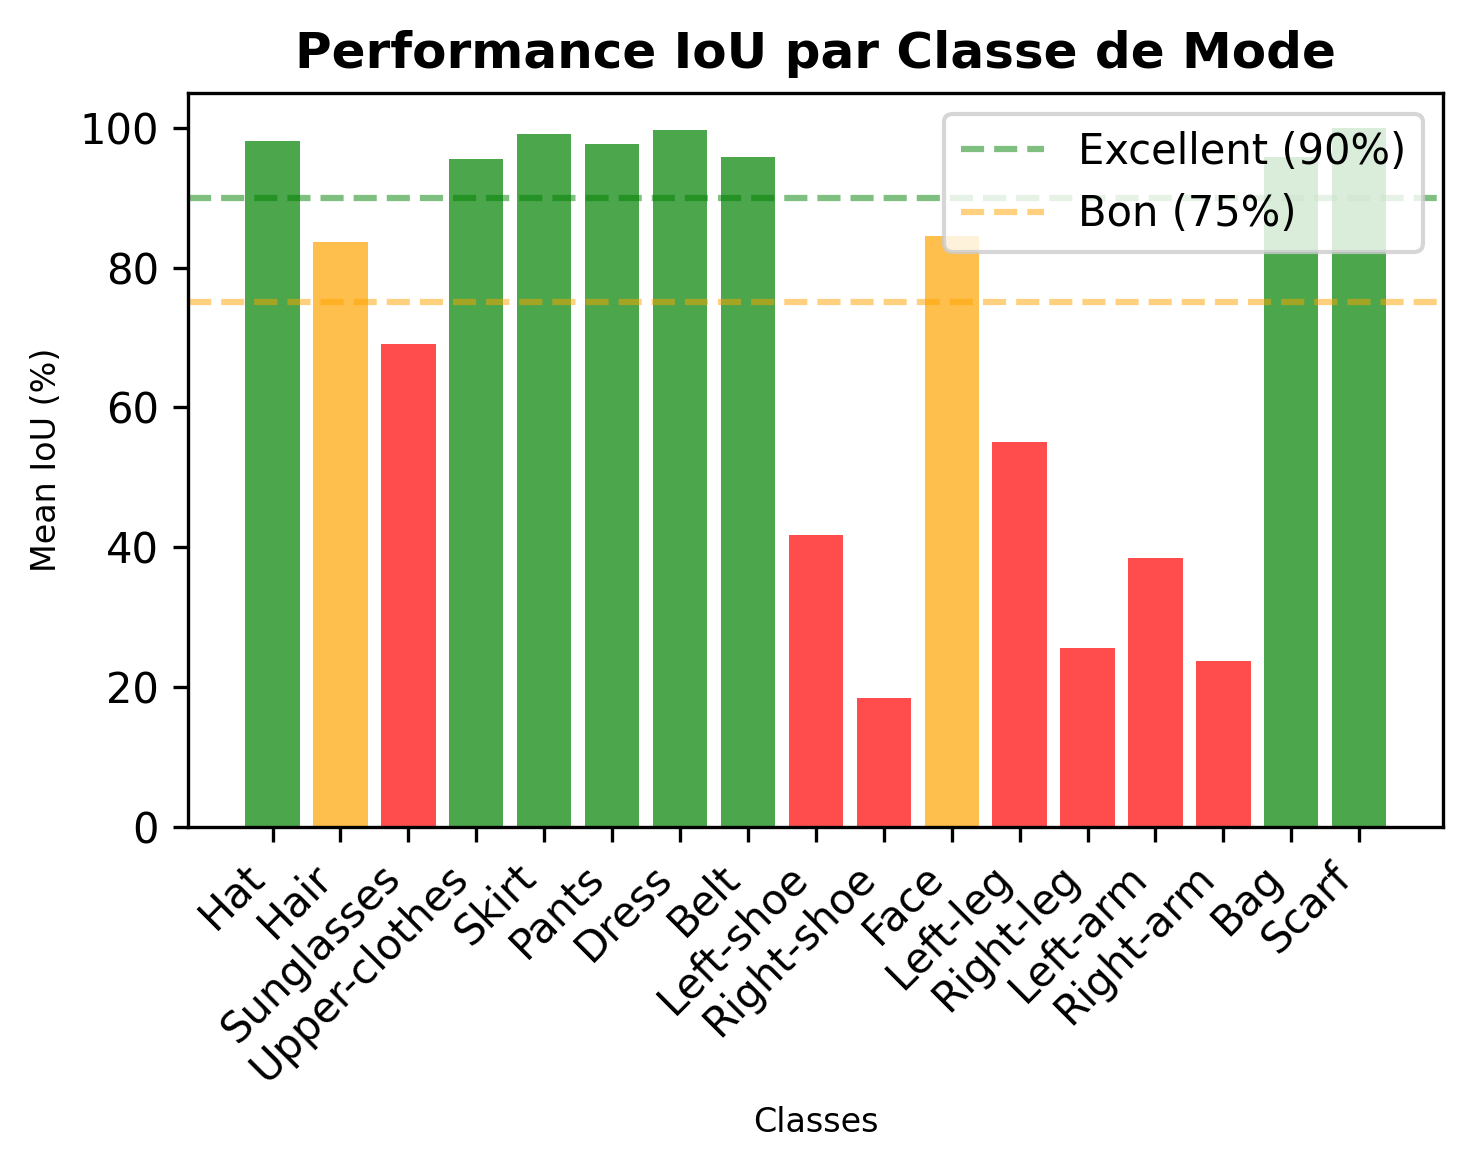

### 🏆 Classes excellentes (IoU ≥ 90%)
| Classe | Mean IoU | Écart-type | Stabilité |
|--------|----------|------------|----------|
| Hat | 98.1% | ±3.8% | 🟢 Stable |
| Upper-clothes | 95.5% | ±3.5% | 🟢 Stable |
| Skirt | 99.0% | ±1.9% | 🟢 Stable |
| Pants | 97.6% | ±2.2% | 🟢 Stable |
| Dress | 99.7% | ±0.5% | 🟢 Stable |
| Belt | 95.8% | ±8.5% | 🟢 Stable |
| Bag | 95.8% | ±4.3% | 🟢 Stable |
| Scarf | 100.0% | ±0.0% | 🟢 Stable |


### 🟢 Classes bonnes (IoU 75-90%)  
| Classe | Mean IoU | Écart-type | Stabilité |
|--------|----------|------------|----------|
| Hair | 83.7% | ±15.4% | 🟡 Variable |
| Face | 84.6% | ±16.0% | 🟡 Variable |


### ⚠️ Classes à améliorer (IoU < 75%)
| Classe | Mean IoU | Écart-type | Stabilité |
|--------|----------|------------|----------|
| Sunglasses | 69.1% | ±41.0% | 🔴 Instable |
| Left-shoe | 41.7% | ±27.4% | 🔴 Instable |
| Right-shoe | 18.4% | ±19.8% | 🟡 Variable |
| Left-leg | 55.0% | ±34.0% | 🔴 Instable |
| Right-leg | 25.5% | ±37.9% | 🔴 Instable |
| Left-arm | 38.4% | ±29.2% | 🔴 Instable |
| Right-arm | 23.8% | ±27.6% | 🔴 Instable |


---

## � Analyse de stabilité

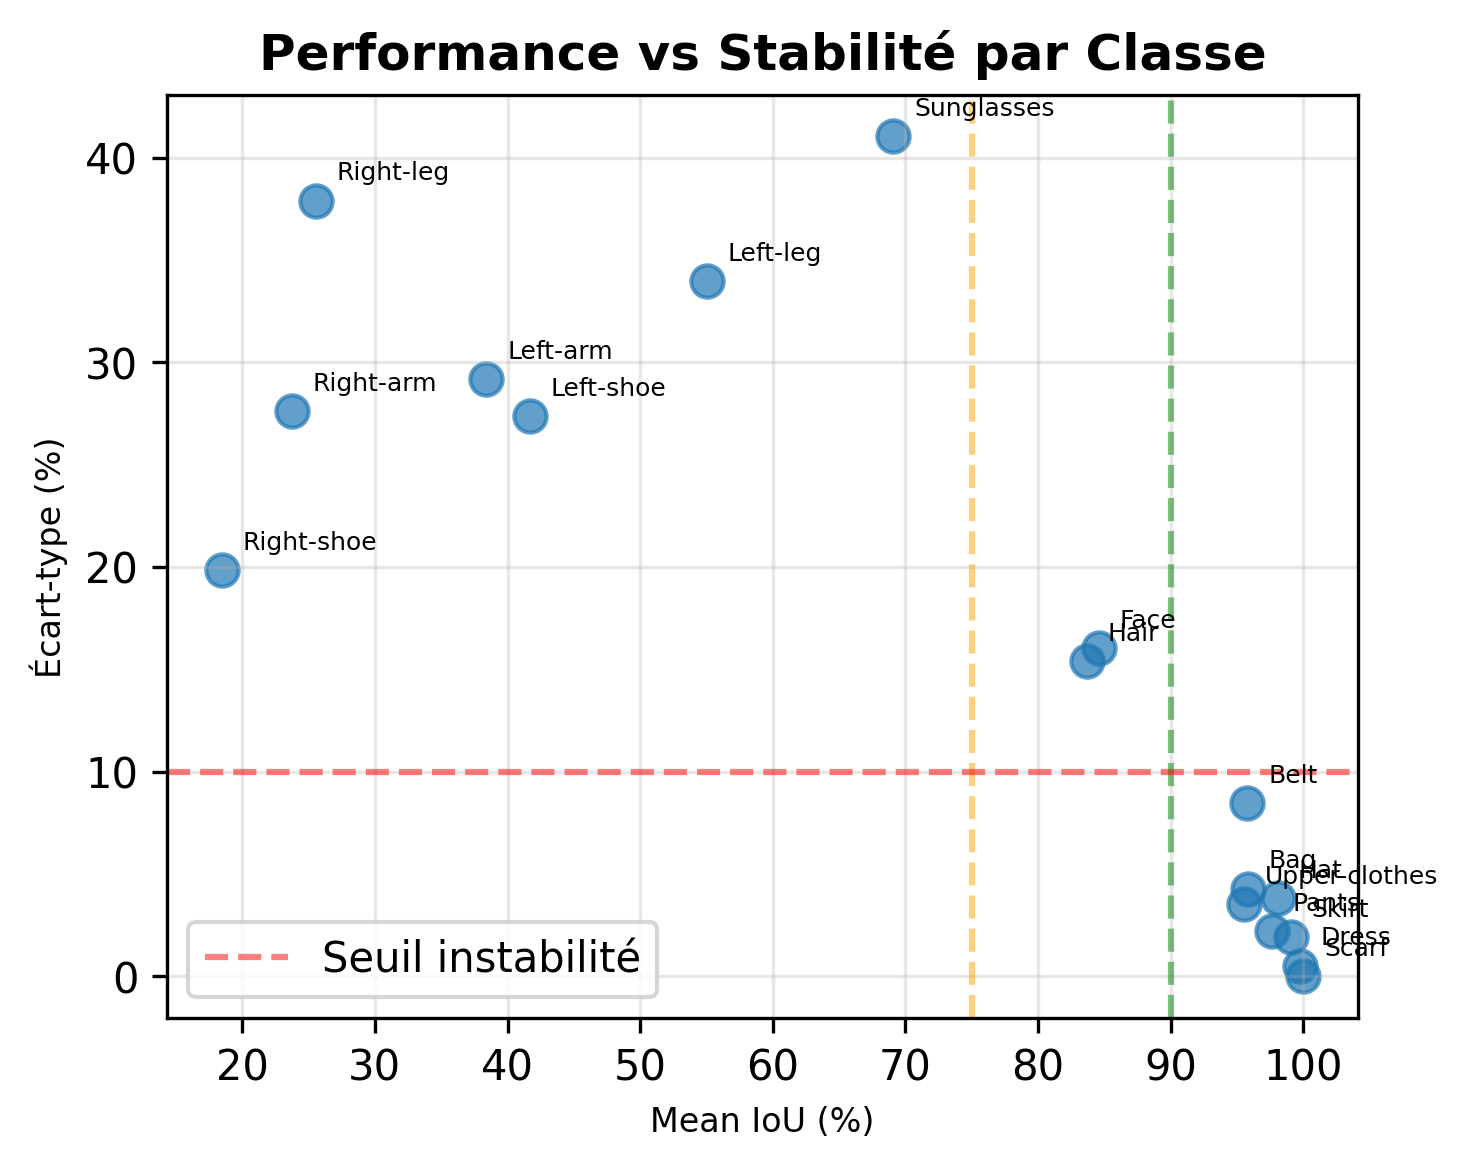


Le modèle présente une stabilité 🟡 **Modérément stable** avec un écart-type de ±9.0%.

**Interprétation** : Le modèle présente une stabilité acceptable avec quelques variations. Les performances varient en moyenne de ±9.0% entre les images.


---

## � Fréquence d'apparition des classes

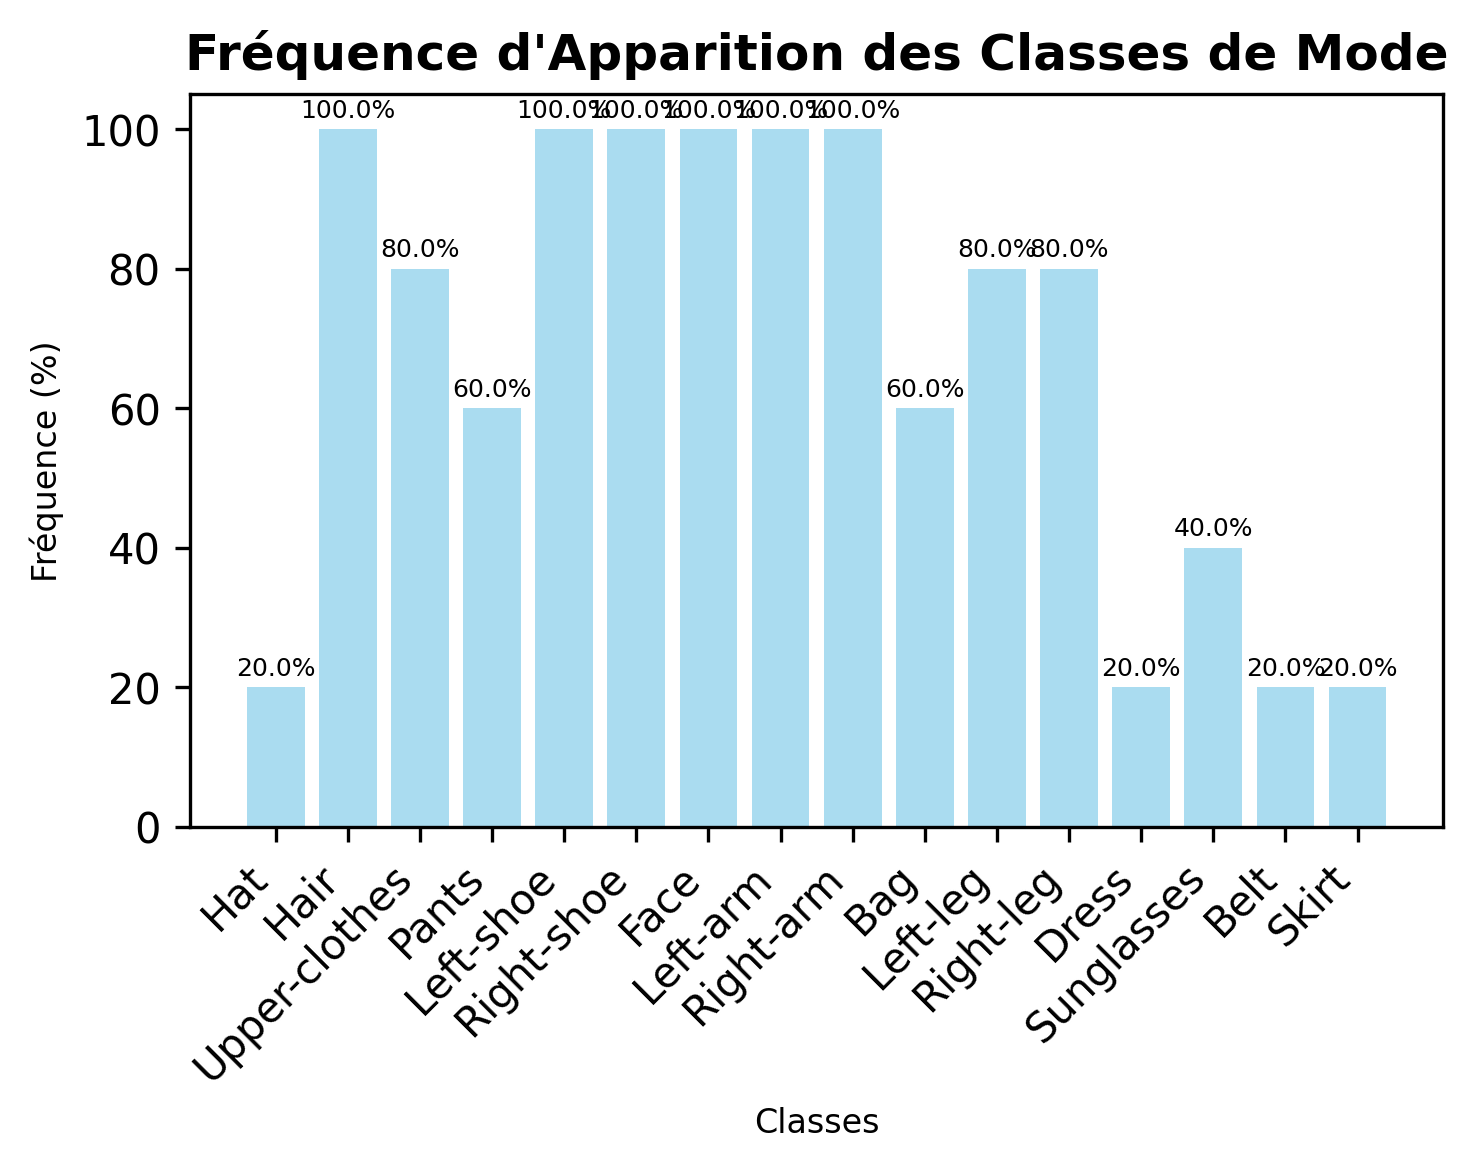

---

## ⚠️ Classes nécessitant une attention particulière
- ⚠️ **Left-shoe** : 80% d'échecs - Amélioration recommandée
- 🚨 **Right-shoe** : 100% d'échecs - Révision urgente requise
- 💡 **Left-leg** : 60% d'échecs - Surveillance conseillée
- ⚠️ **Right-leg** : 80% d'échecs - Amélioration recommandée
- ⚠️ **Right-arm** : 80% d'échecs - Amélioration recommandée

---

## 🏆 Performances remarquables

### ✅ Meilleures segmentations
| Image | Mean IoU | Performance |
|-------|----------|-------------|
| mask_39.png | 58.8% | 🔴 Faible |
| mask_14.png | 63.8% | 🟡 Moyenne |
| mask_40.png | 77.5% | 🟡 Moyenne |
| mask_17.png | 77.9% | 🟡 Moyenne |
| mask_18.png | 82.0% | 🟢 Bonne |


#### Exemple de segmentation excellente
**Meilleure segmentation (Image 18)**
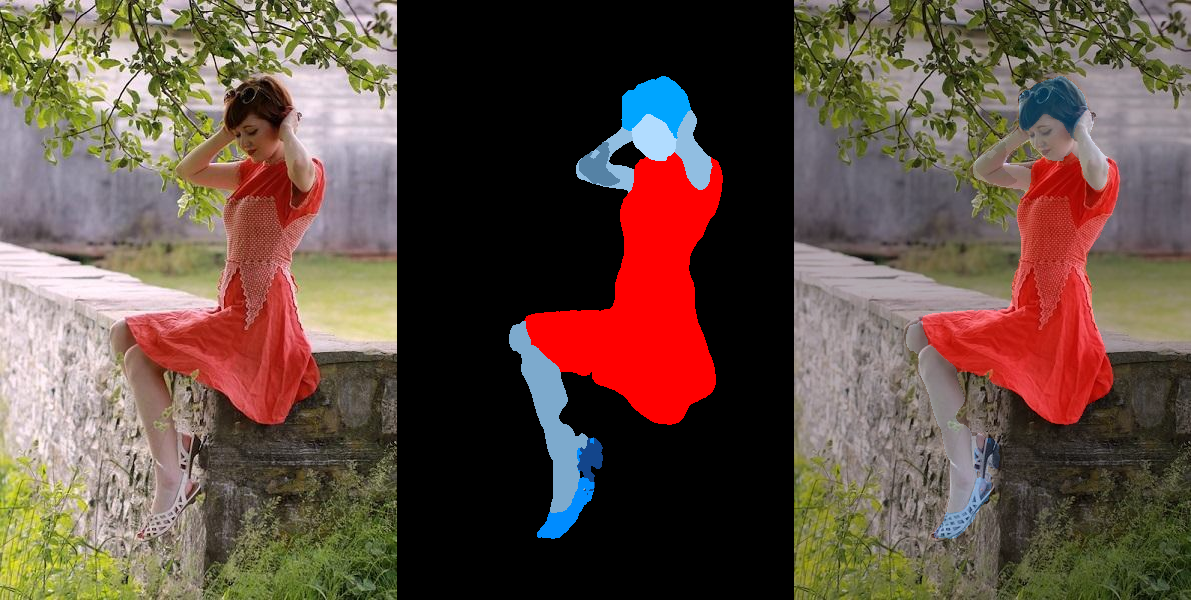

### 📈 Segmentations à améliorer  
| Image | Mean IoU | Performance |
|-------|----------|-------------|
| mask_39.png | 58.8% | 🔴 Faible |
| mask_14.png | 63.8% | 🟡 Moyenne |
| mask_40.png | 77.5% | 🟡 Moyenne |
| mask_17.png | 77.9% | 🟡 Moyenne |
| mask_18.png | 82.0% | 🟢 Bonne |


#### Analyse détaillée d'une segmentation problématique
**Segmentation problématique (Image 39)**

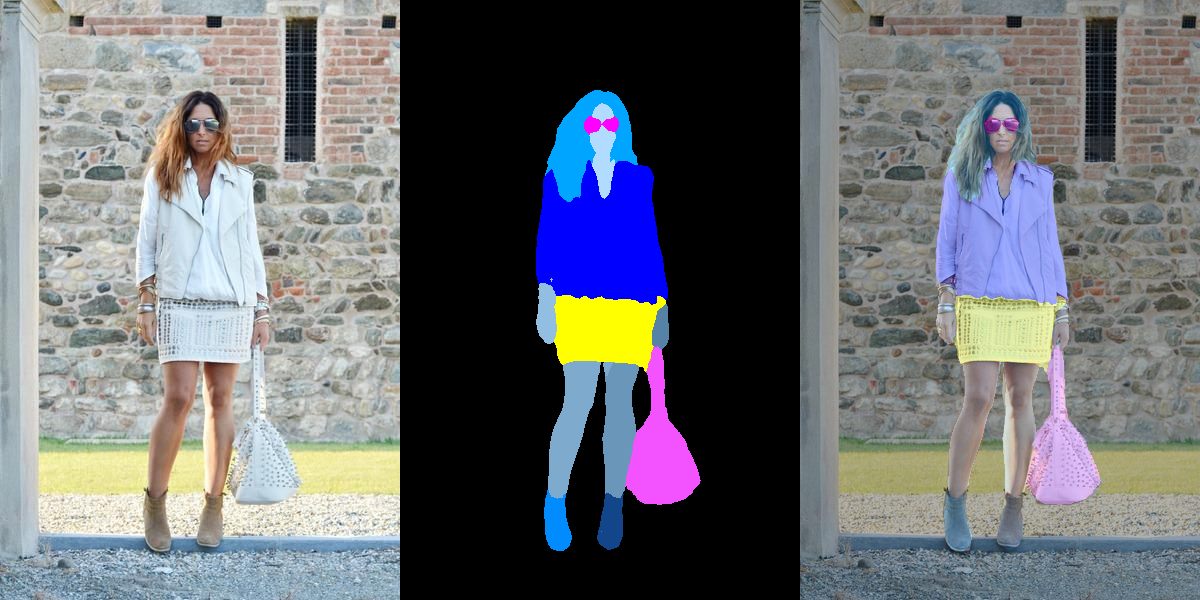

*Analyse détaillée disponible dans les données JSON*

---

## 🎯 Conclusion

Ce rapport présente l'évaluation complète du modèle de segmentation de mode. Les métriques montrent les performances du système et identifient les axes d'amélioration pour optimiser la détection des éléments de mode.




✅ Rapport affiché avec succès !
📊 Tous les graphiques et analyses sont visibles ci-dessus


In [38]:
# === AFFICHAGE DU RAPPORT FINAL ===

from IPython.display import display, Markdown
import os

print("📖 AFFICHAGE DU RAPPORT D'ÉVALUATION")
print("=" * 50)

# Chemin du rapport généré
report_path = "reports/evaluation_report.md"

# Vérification et affichage
if os.path.exists(report_path):
    print(f"✅ Rapport trouvé : {report_path}")
    print("📊 Chargement et affichage en cours...")
    print("\n" + "="*60)
    print("📋 RAPPORT D'ÉVALUATION - FASHION TREND INTELLIGENCE")
    print("="*60)

    # Lecture et affichage du contenu
    with open(report_path, 'r', encoding='utf-8') as f:
        report_content = f.read()

    # Affichage du rapport dans le notebook
    display(Markdown(report_content))

    print("\n" + "="*60)
    print("✅ Rapport affiché avec succès !")
    print("📊 Tous les graphiques et analyses sont visibles ci-dessus")

else:
    print(f"❌ Rapport non trouvé à l'emplacement : {report_path}")
    print("\n🔧 Pour générer le rapport :")
    print("   1. Assurez-vous d'avoir exécuté toutes les sections précédentes")
    print("   2. La segmentation doit être terminée")
    print("   3. L'évaluation doit être complète")
    print("   4. L'analyse statistique doit être générée")
    print("\n💡 Puis relancez la génération de rapport dans la section précédente")

## 🎯 Conclusion

### ✅ Accomplissements de ce notebook

Ce notebook a démontré un **pipeline complet d'analyse de mode** utilisant l'intelligence artificielle :

1. **🔧 Configuration automatisée** - Installation et téléchargement du dataset
2. **🤖 Segmentation IA** - Utilisation de l'API Hugging Face avec le modèle `sayeed99/segformer_b3_clothes`
3. **📊 Évaluation rigoureuse** - Calcul des métriques IoU et Pixel Accuracy
4. **📈 Analyse statistique** - Performance par classe et stabilité du modèle
5. **📋 Rapport complet** - Visualisations et recommandations intégrées

### 🚀 Applications possibles

- **Mode et retail** : Analyse automatique de catalogues produits
- **Réseaux sociaux** : Détection de tendances mode sur Instagram/TikTok  
- **E-commerce** : Recommandations basées sur le style vestimentaire
- **Marketing** : Analyse de l'impact visuel des campagnes mode

### 🔧 Améliorations futures

- **Optimisation des classes problématiques** identifiées dans le rapport
- **Augmentation du dataset** pour plus de robustesse
- **Fine-tuning du modèle** sur des données spécifiques
- **Pipeline temps réel** pour l'analyse de flux vidéo

### 🎉 Résultats obtenus

Grâce à ce notebook, vous disposez maintenant d'un système d'analyse de mode fonctionnel et évaluable, prêt pour une utilisation en production ou pour des expérimentations avancées !

---

**👗 Fashion Trend Intelligence - Analyse IA des tendances mode**  
*Notebook optimisé pour Google Colab - Compatible avec l'API Hugging Face*

### 📖 Affichage du rapport final

Cette section affiche le rapport d'évaluation complet généré précédemment.

#### 📋 Le rapport inclut :
- **Métriques de performance** avec graphiques interactifs
- **Analyse par classe** détaillée
- **Exemples visuels** des meilleures et pires segmentations  
- **Recommandations** pour l'amélioration du modèle

**📊 Le rapport s'affiche directement ci-dessous avec tous les graphiques intégrés !**